## 简单线性回归

### 导入相关库

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

我是用的是python3.5.2(Annaconda)，tensorflow的版本如下

In [3]:
tf.__version__

'1.1.0'

### 导入数据

使用的是Tensorflow自带的Mnist数据集。

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('mnist_data/', one_hot=True)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


mnist数据集一共有70000张图片,其中训练集55000,测试集10000, 验证集5000。这里我们只是用训练集和测试集。

In [5]:
print('Size of:')
print('- Training-set:\t\t{}'.format(mnist.train.labels.shape))
print('- Test-set:\t\t{}'.format(mnist.test.labels.shape))
print('- Validation-set:\t{}'.format(mnist.validation.labels.shape))

Size of:
- Training-set:		(55000, 10)
- Test-set:		(10000, 10)
- Validation-set:	(5000, 10)


### One Hot Encoding

并不是非常复杂的东东，直接输出labels看看就明了了。

In [6]:
mnist.test.labels[:10]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

后面要用到单个数字的表示，所以这里对ont hot encoding做下转换

In [7]:
mnist.test.cls = np.array([label.argmax() for label in mnist.test.labels])

In [8]:
mnist.test.cls[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

### 为模型做准备

#### 一些尺寸参数

In [9]:
img_size = 28 # 图片宽度，长度
img_size_flat = img_size * img_size # 扁平化的图片尺寸
img_shape = (img_size, img_size) # 正规图大小
num_classes = 10 # 类别个数

#### show图片的函数

In [10]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap=plt.cm.binary)
        if cls_pred is None:
            title = 'True:{0}'.format(cls_true[i])
        else:
            title = 'True:{0} Pred:{1}'.format(cls_true[i], cls_pred[i])
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

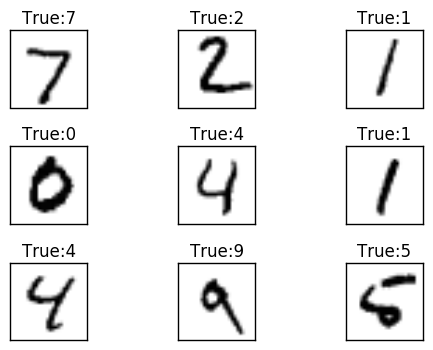

In [11]:
images = mnist.test.images[:9]
cls_true = mnist.test.cls[:9]
plot_images(images, cls_true)

### 开始使用Tensorflow

In [12]:
x = tf.placeholder(dtype=tf.float32, shape=[None, img_size_flat])
y_true = tf.placeholder(dtype=tf.float32, shape=[None, 10])
y_true_cls = tf.placeholder(dtype=tf.int64, shape=[None])

In [13]:
W = tf.Variable(tf.zeros(shape=[img_size_flat,  num_classes]))
b = tf.Variable(tf.zeros(shape=[num_classes]))

直接一个线性函数

In [14]:
logits = tf.matmul(x, W) + b

因为考虑到线性函数的输出有可能特别小，也有可能特别大，这里加上softmax增加模型的解释性

In [15]:
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)

损失函数使用cross_entropy

In [16]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, 
                                                        labels=y_true)
loss = tf.reduce_mean(cross_entropy)

In [17]:
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(loss)

做一个accuracy

In [18]:
correct_predition = tf.equal(y_true_cls, y_pred_cls)
accuracy = tf.reduce_mean(tf.cast(correct_predition, dtype=tf.float32))

run run run!!!

In [19]:
sess =tf.InteractiveSession()

In [20]:
tf.global_variables_initializer().run()

定义一个打印accuracy的函数

In [21]:
def print_accuracy():
    acc = accuracy.eval(test_feed_dict)
    print('Accuracy on test-set: {0:.1%}'.format(acc))

In [22]:
test_feed_dict = {x: mnist.test.images, 
                  y_true: mnist.test.labels, 
                  y_true_cls: mnist.test.cls}
# 模型还没有训练的时候的正确率
print_accuracy()

Accuracy on test-set: 9.8%


定义一个显示错误分类的样本的函数

In [23]:
def plot_example_errors():
    correct, cls_pred = sess.run([correct_predition, y_pred_cls], feed_dict=test_feed_dict)
    incorrect = (correct == False)
    images = mnist.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = mnist.test.cls[incorrect]
    plot_images(images[:9], cls_true[:9], cls_pred[:9])

定义一个optimize函数

In [24]:
def optimize(num_iterations, batch_size=100):
    for i in range(num_iterations):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        train_step.run(feed_dict={x: batch_xs, y_true: batch_ys})

定义一个显示权重的函数

In [25]:
def plot_weights():
    weights = sess.run(W)
    w_min = np.min(weights)
    w_max = np.max(weights)
    
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            img = weights[:, i].reshape(img_shape)
            ax.imshow(img, vmin=w_min, vmax=w_max, cmap=plt.cm.seismic)
            ax.set_title('Weight:{0}'.format(i))
        ax.set_xticks([])
        ax.set_yticks([])

### 仔细看看训练前后

没有训练的时候

In [26]:
print_accuracy()

Accuracy on test-set: 9.8%


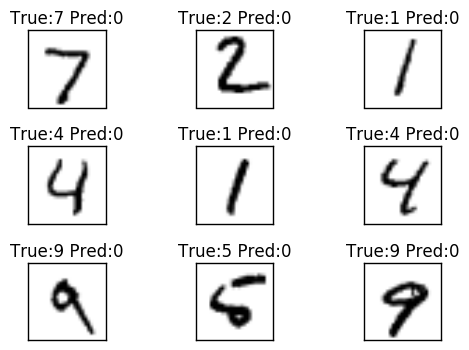

In [27]:
plot_example_errors()

#### 一次迭代训练过后

In [28]:
optimize(num_iterations=1)

In [29]:
print_accuracy()

Accuracy on test-set: 39.5%


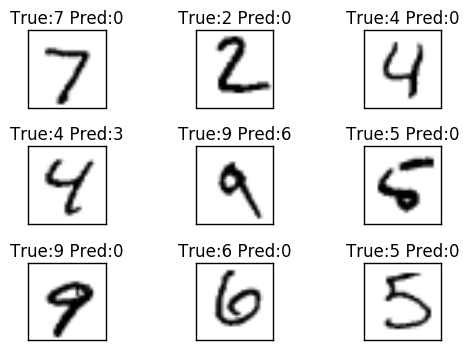

In [30]:
plot_example_errors()

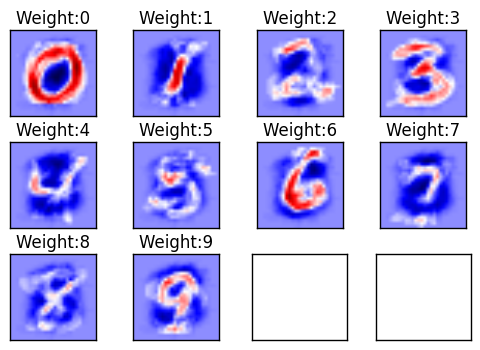

In [31]:
plot_weights()

#### 10次迭代训练过后

In [32]:
optimize(num_iterations=9)

In [33]:
print_accuracy()

Accuracy on test-set: 70.2%


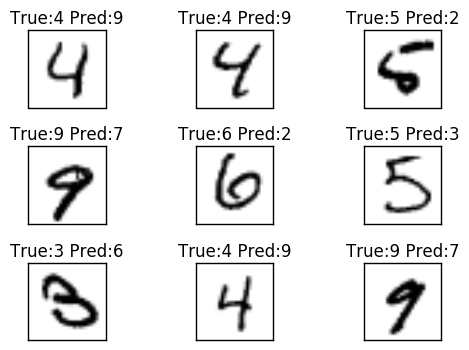

In [34]:
plot_example_errors()

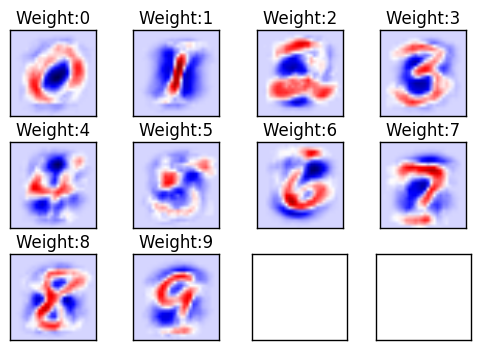

In [35]:
plot_weights()

#### 1000次迭代训练过后

In [36]:
optimize(num_iterations=990)

In [37]:
print_accuracy()

Accuracy on test-set: 91.9%


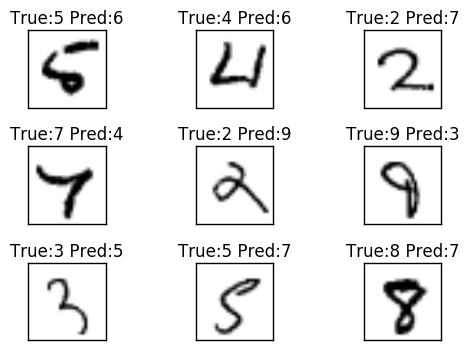

In [38]:
plot_example_errors()

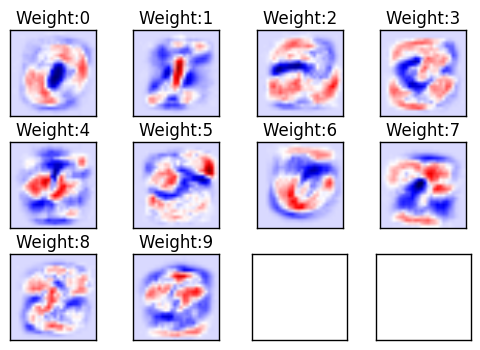

In [39]:
plot_weights()

一千次迭代过后，正确率有91.3%。从上面也可以看出，mis-classification都是一些写的怪里怪气的数字，对我们的线性模型来说已经没法区分了。

刚开始一次迭代的时候，weights图是比较直观，还能够分辨相应的数字，不过当模型遇到了更多的手写数字，它的泛化能力增强，也就不局限单一的几张图片了，这也是1000次迭代训练过后，直接看weights图的话解释能力弱了不少的原因。（补充，红色代表positive，蓝色代表negative）

### confusion matrix

In [40]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix():
    
    y_true = mnist.test.cls
    y_pred = sess.run(y_pred_cls, feed_dict=test_feed_dict)
    
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    ticks_marks = np.arange(num_classes)
    plt.xticks(ticks_marks, range(num_classes))
    plt.yticks(ticks_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

[[ 946    0    5    2    0    9   11    4    3    0]
 [   0 1113    2    2    0    2    4    2   10    0]
 [   4    8  913   22   11    2   11   10   41   10]
 [   0    1   15  946    0   13    2   10   15    8]
 [   1    3    6    1  897    0   14    2    7   51]
 [   9    4    6   64    9  725   19    9   38    9]
 [   7    3    4    2    9   10  920    1    2    0]
 [   1   11   21    9    6    0    0  941    1   38]
 [   3   11    6   32    9   18   11   10  861   13]
 [   9    8    2   13   25    4    0   17    6  925]]


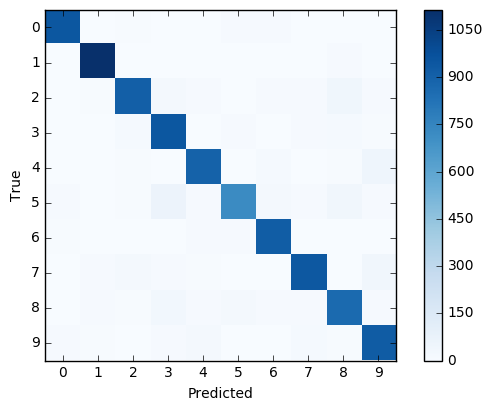

In [41]:
print_confusion_matrix()